# Exercise 1 for the class EE-568 Theory and Methods of Reinforcement Learning taught at EPFL in Spring 2024 by Prof. Volkan Cevher

In [9]:
# %pip install -r requirements.txt

import os
from typing import List

import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys

sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from plot import plot_log_lines, plot_lines
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dynamic Programming exercise

We will make use of the operators introduced in the slides of lectures 1 and 2. 
$(T V)(s)$, $\mathcal{G}$ and $T^{\pi}$

Before diving into the implementation of Value Iteration or Policy Iteration, we instantiate an environment using the library in the foilder `src`.

The gridworld environment is instantiated via the class `GridWorldEnvironment`. It takes 4 input values:

- `reward_mode` : integer between 0 and 3 for different reward profiles
- `size`: Gridworld size
- `prop`: probability assigned to the event that the agent do not follow the chosen action but another one selected uniformely at random.
- `gamma`: the discount factor of the environment.

In [10]:
reward_mode = 2 # put an image to show which is the reward
size = 10 
prop = 0
gamma=0.99 # rename discount_factor
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

Below, we illustrate how to access the gridworld environment, i.e. how to access the reward, the transition matrix and the discount factor.

In [11]:
size = 3
gridworld_example = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)


In [12]:
# print(gridworld.r)

***Interface with a Gridworld instance***
- `print(gridworld.n_states)` #return the number of states
- `print(gridworld.n_actions)` #return the number of actions
- `print(gridworld.r)` #return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` #Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.



<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

Then we set up the solver object that will implement the routine needed to evaluate the value of the produced policies

In [13]:
solver = MDPsolver(gridworld)

We will use this solver to compute the optimal value function to measure the suboptimality of the policies produced by value iteration or policy iteration.

To access the optimal value function use `solver.v`.

In [41]:
solver.value_iteration()

# print(solver.v)

## Ex 1: Value Iteration [35 pts.]

### 1.1 Implement value iteration

In [15]:
def value_iteration(env, tol=1e-10):
    """Inplementation of value iteration, note that the implementation is based on Q-value iteration mentioned in the lecture.
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        policies: policy  at each iteration (list)
        vs: value functions at each iteration (list)
    """
    policies = []
    vs = []
    v = np.zeros(env.n_states) # initialize value function
    q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
    
    while True:
        v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v) # calculate Q-value
        v = np.max(q, axis=1) # update value function
        policies.append(np.argmax(q, axis=1)) # obtain policy
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol: # convergence criterion
            break
    return policies, vs

In [16]:
policies, vs = value_iteration(gridworld)

In [17]:
# print(f"optimal policy: {policies[-1]}")
# print(f"Result of value iteration: {vs[-1]}")

### 1.2: Evaluate the extracted policies

For the evaluation of the sequence of policies, i.e. computing $V^\pi$ for each policy $\pi$ we recall that $V^\pi$ is the fixed point $V^\pi = T^\pi (V^\pi)$.
In the following code, we ask you to apply the operator $T^\pi$ a number of time sufficient to find a value $V$ such that $ || T^\pi(V) - V || \leq \mathrm{tol}$

In [18]:
def evaluate_policy_sequence(policies, env: GridWorldEnvironment, tol=1e-10):
    """Inplementation of policy evaluation through iteratively applying policy value iteration 
    Args:
        policies: a list of policies obtained by section 1.1
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        values: a list of value function for each policy
    """
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)  #calculate Q-value
            for s in range(env.n_states):
                action_taken = pi[s] # obtain the action determined by the policy
                v[s] = q[s, action_taken] #calculate value function by $v(s) = max_a Q(s,a)$
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [19]:
values = evaluate_policy_sequence(policies, gridworld)

### 1.3: Plot the results 

Plot using the method ```plot_lines(list_to_plot, list_name, axis_label, folder, title, x_axis = None, show = False) ```

Compute both the iterates $V_t$ produced by value iteration and the value function achieved by the extracted policies $V^{\pi_t}$ with $\pi_t = \mathcal{G}(V_t)$. What do you observe ?


$V_t$ steadily reaches the exact solution of $V^*$

In [20]:
def compute_subopt(values, v_star):
    """
    Args:
        values: a list of value function.
        v_star: the optimal value function obtained by MDP.solver
    Returns:
        subopts: an array indicates the suboptimality.
    """
    subopts = []
    for v in values:
        i = np.argmax(np.abs(v - v_star))
        subopts.append(-v[i] + v_star[i])
    return np.array(subopts)

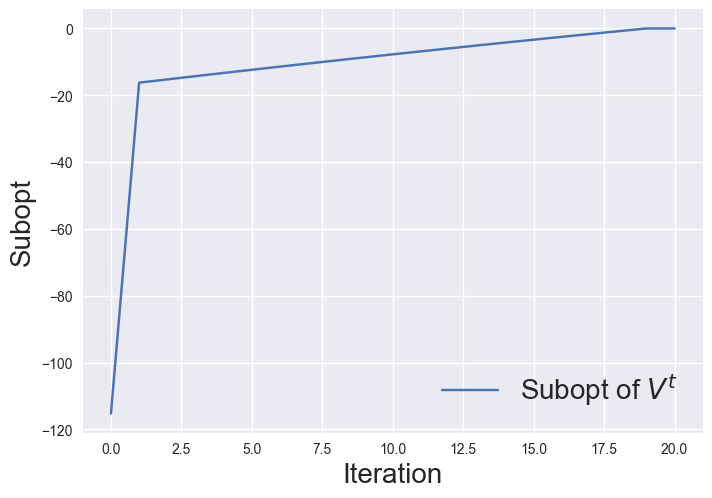

In [21]:
plot_lines([compute_subopt(vs, solver.v)], [r"Subopt of $V^t$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

**Question** : 
- Prove that $T$ is a contraction, that is $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$.
- Why the iterates of Value Iterations are an upper bound to $V^\star$ ? How is this possible considering that $V^\star \triangleq \max_{\pi \in \Pi} V^{\pi}$ ?

**Answers**

- Experimentally we can look at our plot and conclude that the error between $V^\star$ and $V$ becomes steadily smaller over time.

    We can apply the definition of the Bellman optimality operator to the left side of the inequality.

    $|| T(V) - T(V') ||_{\infty} = ||\max_{a \in A}[r(s,a)+\gamma \sum_{s' \in S} P(s' | s, a) V(s')] - \max_{a \in A}[r(s,a)+\gamma \sum_{s' \in S} P(s' | s, a) V'(s')] ||_{\infty}$

    using triangular inequality:
    
    $\leq \max_{a \in A}||[r(s,a)+\gamma \sum_{s' \in S} P(s' | s, a) V(s')] - [r(s,a)+\gamma \sum_{s' \in S} P(s' | s, a) V'(s')] ||_{\infty}$

    $= \max_{a \in A}||\gamma \sum_{s' \in S} P(s' | s, a) [V(s')-V'(s')]||_{\infty}$

    again triangular inequality:

    $\leq \max_{a \in A}\gamma \sum_{s' \in S} P(s' | s, a) |[V(s')-V'(s')]|$

    $= \gamma \max_{a \in A} \sum_{s' \in S} P(s' | s, a) |[V(s')-V'(s')]|$

    $\leq \gamma ||V-V'||_{\infty} \max_{a \in A} \sum_{s' \in S} P(s' | s, a)$

    Whereas the sum to go from state $s'$ to state $s$ under action $a$ over all states is alwawys equal to 1

    $\rightarrow = \gamma ||V-V'||_{\infty}$

    This concludes the proof of $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$

- The iterates of $V_t$ of Value Iteration are approximations. As all the rewards of the environement are negative $V^*(s)\leq 0 \quad \forall s \in \mathcal{S}$. Since our initial guess is $V^0(s)=0 \quad \forall s \in \mathcal{S}$ we will approach $V^*$ from above. Thus leading to $V^t>V^*$

But as soon as we evaluate $V_t$ with the found best policy $\pi_t$ we see that $V^{\pi_t} \leq V^*$, i.e. $V^* = \max_{\pi \in \Pi} V^{\pi}$

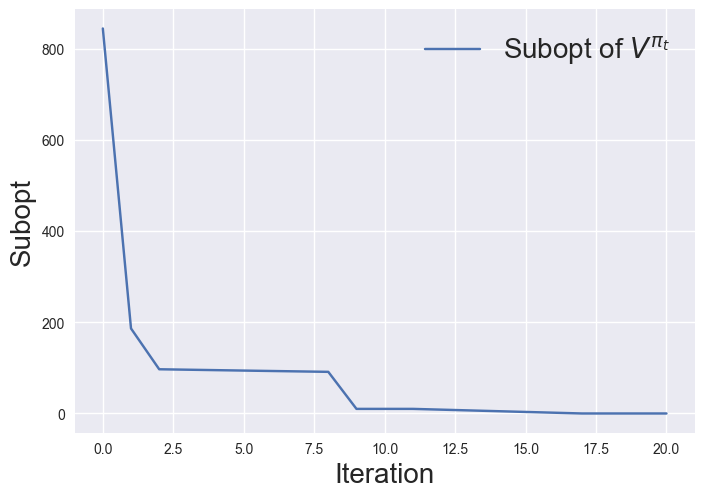

In [22]:
plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

To better appreciate the difference in the convergence plot use log scale.

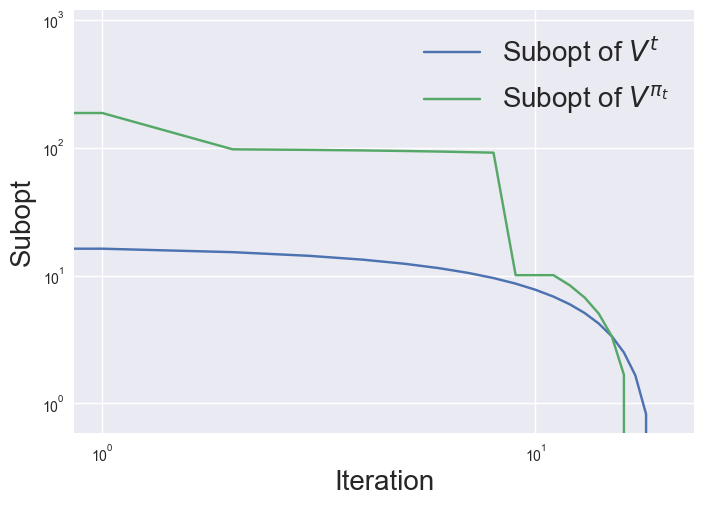

In [23]:
plot_log_lines([-compute_subopt(vs, solver.v), compute_subopt(values, solver.v)], 
               [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"], 
               ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

# Ex 2: Policy Iteration [35 pts.]

In [24]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [25]:
def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = []
    for s in range(q.shape[0]):
        policy.append(np.argmax(q[s]))
    return policy

In [26]:
def policy_iteration(env, tol=1e-20):
    """Implementation of policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env)
        pi = get_greedy_policy(q)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs

In [27]:
values_pi=policy_iteration(gridworld)

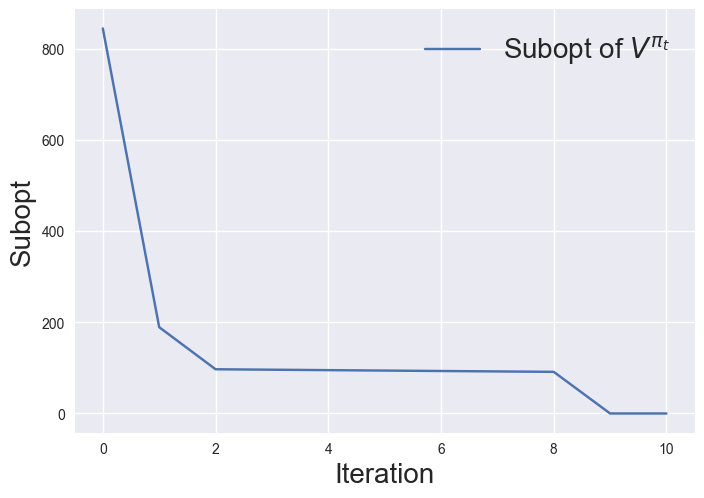

In [28]:
plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

### Compare with Value Iteration

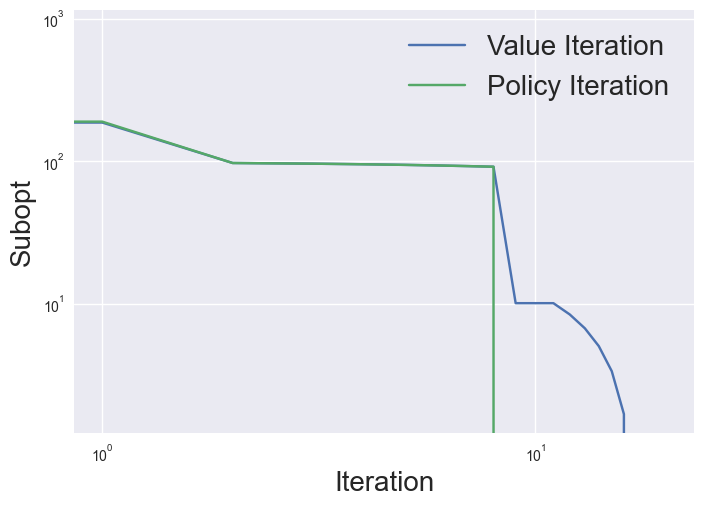

In [29]:
plot_log_lines([compute_subopt(values, solver.v), compute_subopt(values_pi, solver.v)], 
               ["Value Iteration", "Policy Iteration"], 
               ["Iteration", "Subopt"], "figs", "VIvsPI.pdf", show = True)

***Questions :*** 
- Which algorithm converges faster ?
- Is it theoretically expected ? Answer listing the expected number of iterations needed for VI and PI to converge ?


***Answers***

- Policy Iteration converges faster
- Expected max iterations for VI:

    $T = \mathcal{O}(\frac{log(\epsilon (1-\gamma))}{log(\gamma)})$ whereas $\epsilon = 1 \mathrm{e}{-}10, \gamma=0.99$

    $T= \mathcal{O}(\frac{log(1 \mathrm{e}{-}10 (1-0.99))}{log(0.99)})=2750$

- For PI:
    
    $T = \mathcal{O}(\frac{|S|(|A|-1)}{1-\gamma})$ whereas $|S| = 100, |A| = 4, \gamma=0.99$

    $T = \mathcal{O}(\frac{100*3}{1-0.99}) = 30000$

***Theory Questions*** 
- Prove the policy improvement theorem.
- Prove that the Bellman operator is monotone elementwise. That is if $V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$.

***Answers***

**Policy Improvement Theorem**

$Q_\pi(s, \pi'(s)) \geq V_\pi(s)$

**Proof:**

Recall the definitions:

$V^{\pi}(s)=\mathbb{E}_{\pi}[\sum_{t=0}^{\infty}\gamma^t r(s_t, a_t) | s_0=s]$

$Q^{\pi}(s, a)=\mathbb{E}_{\pi}[\sum_{t=0}^{\infty}\gamma^t r(s_t, a_t) | s_0=s, a_0=a]$

As well as the relation between $Q^\pi$ and $V^\pi$:

$Q^{\pi}(s, a)=r(s, a)+ \gamma \sum_{s' \in \mathcal{S}} P(s'|s, a)V^\pi(s')$ 

$V^{\pi}(s)=\sum_{a \in \mathcal{A}} \pi(a|s)Q^\pi(s,a)$ 

By the definition of $ Q_\pi(s, a) $ and the relation with $V^\pi$, we have:

$Q_\pi(s, \pi'(s)) = \mathbb{E}_{\pi'}[\sum_{t=0}^{\infty}\gamma^t r(s_t, \pi'(s)) | s_0=s, a_0=a]$

$=\mathbb{E}_{\pi'}[r(s_0, \pi'(s))+ \gamma V^\pi(s_1)|s_0=s]$

$\leq \mathbb{E}_{\pi'}[r_0+ \gamma Q^\pi(s_1, \pi'(s_1))|s_0=s]$

$\leq \mathbb{E}_{\pi'}[r(s_0, \pi'(s))+ \gamma r_1 + \gamma V^\pi(s_2)|s_0=s]$

$\leq \mathbb{E}_{\pi'}[r(s_0, \pi'(s))+ \gamma r_1 + \gamma^2 Q^\pi(s_2, \pi'(s_2))|s_0=s]$

$\leq \mathbb{E}_{\pi'}[r(s_0, \pi'(s))+ \gamma r_1 + \gamma^2 r_2 + \gamma^2 V^\pi(s_2)|s_0=s]$

$\leq ...$

$\leq \mathbb{E}_{\pi'}[r(s_0, \pi'(s))+ \gamma r_1 + \gamma^2 r_2 + \gamma^3 r_3 + ...|s_0=s] = V^{\pi'}(s)$

Which is the definition of $V^{\pi'}(s)$ and thus concludes the proof.

**Monotonicity of Bellman Operator**
What we want to prove:

$V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$

Recall the definition of $T^\pi V=R^\pi+\gamma P^\pi V$

Writing this for $V$ and $V'$:

$T^\pi V=R^\pi+\gamma P^\pi V \quad \quad T^\pi V'=R^\pi+\gamma P^\pi V'$

Since $V>V' \rightarrow R^\pi+\gamma P^\pi V \geq R^\pi+\gamma P^\pi V'$

Which concludes the proof.

# Ex 3: Modified Policy Iteration [15 pts.]

In this cell you will code and run Modified Value Iteration, that follows this pseudocode:
- $\pi_{k+1} = \mathcal{G}(V_k)$
- $V_{k+1} = T^m_{\pi_{k+1}}(V_k)$

In the implementation, we will use also the variable $Q$ as in the previous implementation of VI and PI for convenience of implementation.

**Questions**

Which value of $m$ recovers policy iteration ?
Which value of $m$ recovers value iteration ?

***Answers***

Value iteration is recovered by m = 1

Policy iterations is recovered by $m=\infty$ (until $V_{k+1}$ converges)

First, write a function that applies the Bellman evaluation operator $m$ times

In [30]:
def policy_operator_m_times(pi, m, env: GridWorldEnvironment, v, q):
    """Implementation of partial policy evaluation through applying m times the Bellman operator
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
        v: initial value vector
        q: initial state action value vector
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    i = 0
    while i < m:
        for a in range(env.n_actions):
            q[:, a] = env.r[:,a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]
        i = i + 1
    return v, q

At this point, using the function `get_greedy_policy` implemented for PI you are ready to implement Modified Policy Iteration !

In [31]:
def modified_policy_iteration(env, m, tol=1e-10):
    """Implementation of modified policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        pi = get_greedy_policy(q)
        v, q = policy_operator_m_times(pi, m, env, v, q) 
        policies.append(get_greedy_policy(q))
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,policies

Now run modified policy iteration for different values of $m$ for example between $1$ and $10$. 

In [32]:
m_values = ["1", "2", "3", "5", "10", "20"]
to_plot = []
for m in m_values:
    m = int(m)
    _, policies_mpi=modified_policy_iteration(gridworld, m)
    values_mpi = evaluate_policy_sequence(policies_mpi, gridworld)
    to_plot.append(compute_subopt(values_mpi, solver.v))

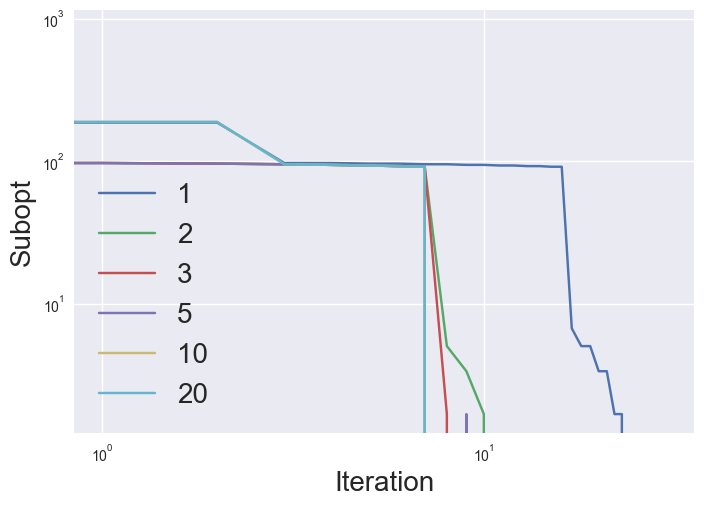

In [33]:
plot_log_lines(to_plot, 
           m_values, 
           ["Iteration", "Subopt"], "figs", "MPI.pdf", show = True)

**Questions** 
- How does the value of $m$ affect convergence ?
- Which is the cost per iteration of Modified Policy Iteration ?
- Which is the cost per iteration of Policy Iteration implemented with Option 2 in the slides ?

***Answers***

- the higher m the faster the convergence.
- $\mathcal{O}(m|S|^2|A|)$, whereas $|S| = 100$, $|A| = 4$
- $\mathcal{O}(|S|^3+ |S|^2|A|)$ whereas $|S| = 100, |A| = 4$

    $\mathcal{O}(100^3+ 100^2 * 4) = 1'040'000$


# Ex 4: Q-Learning [15 pts.]

Now, we are ready to tackle the problem in the model free setting. For technical reason, we focus on the finite horizon setting in this part and we compare two exploration strategies.
1. **$\varepsilon$-greedy** (Watkins, Christopher John Cornish Hellaby. “Learning from Delayed Rewards.” PhD Thesis, King’s College, Cambridge United Kingdom, 1989.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Sample $b_h \sim \text{Bernoulli}(\varepsilon), \hat{a}_h \sim \text{Uniform}(\mathcal{A})$
      - Take action $a_h \leftarrow \left[(1-b_h) \left(\underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}\right) + b_h \hat{a}_h \right]$ and observe $x_{h+1}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha)Q_h(x_h,a_h) +\alpha\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1})\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$
2. **UCB bonuses** (Jin, Chi, Zeyuan Allen-Zhu, Sebastien Bubeck, and Michael I Jordan. “Is Q-Learning Provably Efficient?” In Advances in Neural Information Processing Systems, Vol. 31. Curran Associates, Inc., 2018. https://proceedings.neurips.cc/paper/2018/hash/d3b1fb02964aa64e257f9f26a31f72cf-Abstract.html.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ and $N_h(x,a) \leftarrow 0$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Take action $a_h \leftarrow \underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}$ and observe $x_{h+1}$
      - $t=N_h(x_h,a_h)\leftarrow N_h(x_h,a_h) + 1, \alpha_t = \frac{H+1}{H+t}$ and $b_t \leftarrow c\sqrt{\frac{H^3}{t}}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha_t)Q_h(x_h,a_h) +\alpha_t\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1}) + b_t\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$

For other technical reason, we also need to rescale the reward between 0 and 1, as done in the following

In [34]:
reward_mode = 0
size = 10
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

### Q learning with epsilon greedy 

In this subsection, we implement $Q$ Learning with the simplest possible exploration strategy: $\epsilon$-greedy.

In [35]:
def argmax_with_random_tie_breaking(b):
    return np.random.choice(np.where(b == b.max())[0])

In [36]:
def q_learning_epsilon_greedy(K: int = 100000, H: int = 20, epsilon: float = 0.1, alpha: float = 0.1) -> List[float]:
    """
    Function implementing the epsilon-greedy Q-learning algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param epsilon: Algorithm hyperparameter, exploration probability, float in [0, 1]
    :param alpha: Algorithm hyperparameter, Q update weight, float in [0, 1]

    :return: reward after each step, list of K * H floats
    """
    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            explore = np.random.binomial(2, p=epsilon)
            if explore:
                # Exploration: With probability epsilon take a random action
                a = np.random.choice(gridworld.n_actions)
            else:
                # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
                a = argmax_with_random_tie_breaking(Q[h, state, :])

            # Get reward for action
            rewards.append(gridworld.r[state, a])

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Update Q according to the algorithm
            Q[h, state, a] = (1-alpha)*Q[h, state, a]+alpha*(rewards[-1]+V[h+1, new_state])

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.min([np.max(Q[h, state, :]), H])

            state = new_state
    return rewards

In [37]:
reward_eps_greedy = q_learning_epsilon_greedy()  # You can play around with the arguments if you like
cumulative_reward_eps_greedy = np.cumsum(reward_eps_greedy)

### Q-Learning with bonuses

In this subsection, you are asked to implement an optimistic version of  Q Learning suggested in (Jin et al., 2018)

In [38]:
def q_learning_ucb_bonuses(K: int = 100000, H: int = 20, c: float = 0.0001) -> List[float]:
    """
    Function implementing the Q-learning with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param c: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0
    N = np.ones((H, gridworld.n_states, gridworld.n_actions))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # Take one of the optimal actions for the current state
            a = argmax_with_random_tie_breaking(Q[h, state, :])
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Calculate the UCB bonus
            bonus = c * np.sqrt(H ** 3 / N[h, state, a])

            # Calculate the adaptive alpha according to the algorithm
            alpha = (H + 1) / (H + N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = (1-alpha)*Q[h, state, a] + alpha * (rewards[-1]+V[h+1, new_state]+bonus)

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :])
            V[h, state] = np.clip(V[h, state], 0, H)

            state = new_state

    return rewards

In [39]:
reward_UCB = q_learning_ucb_bonuses()  # You can play around with the arguments if you like
cumulative_reward_UCB = np.cumsum(reward_UCB)

### Comparison of exploration strategies

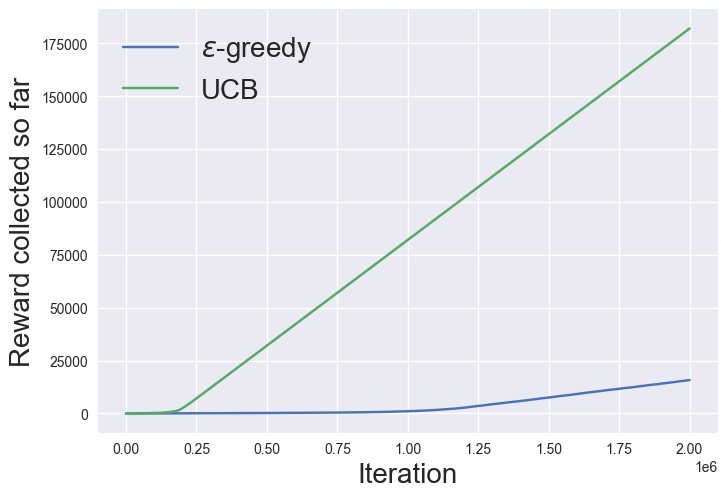

In [40]:
plot_lines(
    [cumulative_reward_eps_greedy, cumulative_reward_UCB],
    [r"$\epsilon$-greedy", "UCB"],
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps.pdf",
    show=True
)

**Question:** You are given an environment with $N$ states linked in a chain, i.e. from every state except the two endpoints there are two possible actions going right or go back to the first state in the chain. For the endpoints the second action is to stay in the same state. The reward is only 1 if you are in the rightmost state and stay there, otherwise 0. What is the probability that the $\varepsilon$-greedy algorithm will have a positive reward after $H$ steps in the first episode, if the chosen initial state is the leftmost state in the chain?

Three cases:
- $H<N-1$ $\rightarrow P=0$, as it is impossible to reach the last state of the chain

- $H=N-1$ $\rightarrow P=(\frac{1}{2})^H$

- $H>N-1$: Most complicated state. Hard to compute exact probability, but possible to bound it.

    upper bound: in every step $h \in H$ the probability to reach the last state within the next $N-1$ steps is $\leq (\frac{1}{2})^{N-1}$ $\Rightarrow P \leq H (\frac{1}{2})^{N-1}$

    lower bound: The individual states are not overlaying $\Rightarrow P \geq \frac{H}{N}(\frac{1}{2})^{N-1}$

**Question:** Does the empirical result match the theoretical result described in (Jin et al. 2018) ? Try to answer this question after reading their Appendix A and looking at their Table 1 for the algorithm they call UCB-H.

For UBC-H: $Regret: \mathcal{O}(\sqrt{H^4SAT})$, whereas $S = 100$, $A = 4, \quad H=20, \quad T=KH=2'000'000$

$\rightarrow \mathcal{O}(\sqrt{H^4SAT})\approx 11'313'708$

For Q learning with $\epsilon$-greedy:
$Regret: \Omega(min[T,A^{H/2}])$

$\rightarrow \Omega(min[2'000'000,1'048'576])=1'048'576$

In summary $\epsilon$-greedy does have a lower bound, so always a minimum regret possible. UBC-H does not have this. So it can be expected that UBC-H collects rewards faster.